In [1]:
# Some imports
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import seaborn as sns
from sklearn import neighbors
from datetime import datetime
from pandas_datareader.data import DataReader
from sklearn.linear_model import LinearRegression
#for normalizing
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
import warnings
warnings.filterwarnings('ignore')

# Importing Intermediate Modules

In [2]:
import importlib
import os
import configparser

from run import Generate_Models
from pre_process import Pre_Process_Data
from readWrite import Read_Write_Data
from buildModels import Build_Model
# !pip install ConfigParser

# Loading Input Data

In [3]:
# Calling module to load data.
# from ConfigParser import SafeConfigParser
read_config = configparser.ConfigParser()
read_config.read("config.ini")

['config.ini']

In [4]:
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
tech_list = ['AAPL', 'NFLX','INTC', 'SONY', 'AMZN', 'IBM']
for stock in tech_list:
    globals()[stock] =  DataReader(stock, 'yahoo', start, end)

company_list = [AAPL, NFLX, INTC, SONY, AMZN, IBM]
company_name = ['Apple', 'Netflix','Intel', 'Sony', 'Amazon', 'IBM']
for company, com_name in zip(company_list, company_name):
    company['company_name'] = com_name

# df = pd.concat(company_list, axis=0)
# df.to_csv("TechStockData.csv")
df = pd.read_csv("TechStockData.csv")
df.head(10)

ChunkedEncodingError: ("Connection broken: ConnectionResetError(104, 'Connection reset by peer')", ConnectionResetError(104, 'Connection reset by peer'))

#### Exploratory Data Analysis

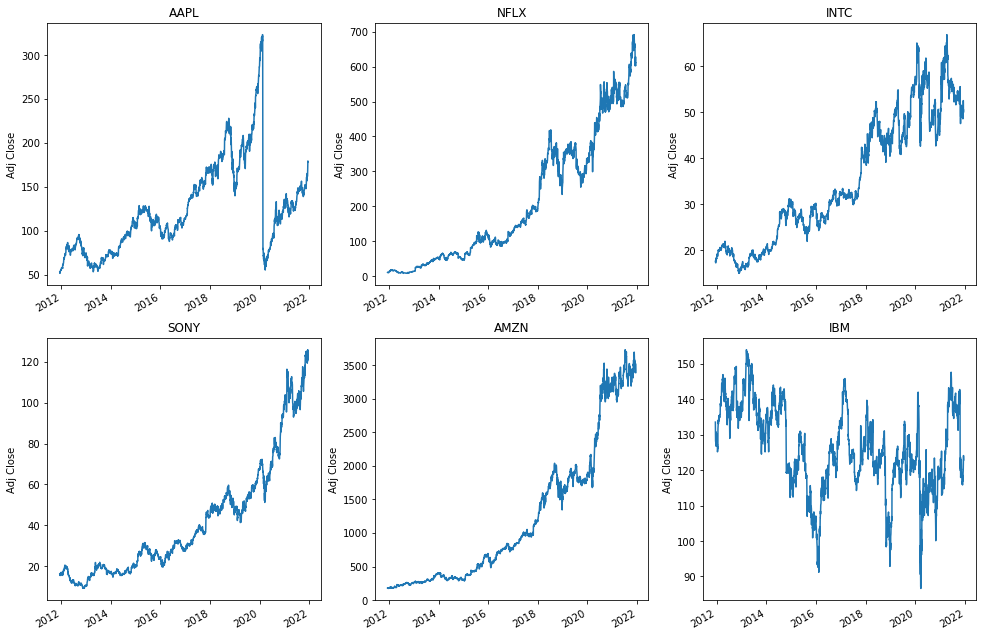

In [8]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.75, bottom=1.5, right=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(3,3, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

Above plots shows the adjusted closing price of all 6 companies from year 2011 to year 2021. It can be observed that, all companies fell  from start of March 2020 . It can be seen that, Apple prices fell the lowest in 2020 as compared to others.

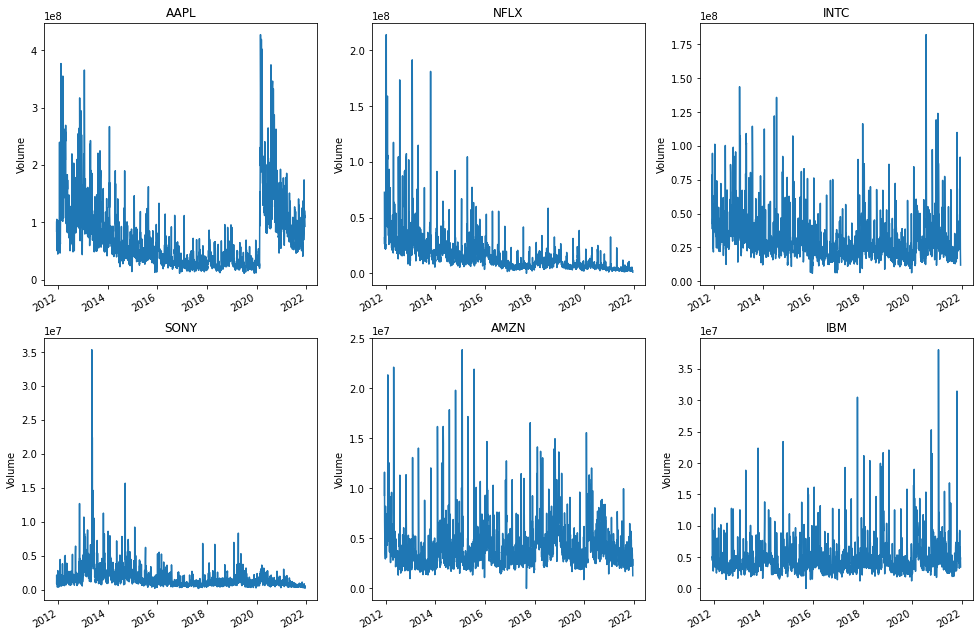

In [9]:
# For plotting the total volume of stock being traded each day
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.75, bottom=1.5, right=1.2)
for i, company in enumerate(company_list, 1):
    plt.subplot(3, 3, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

Above chart shows the volume of shares of the tech companies from 2011 to 2021. It can be seen that in most stocks, the Volume is decreasing year by year

In [10]:
# df = input_dataframe
# df.describe()
df = pd.read_csv("TechStockData.csv")
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,company_name
0,2011-12-13,56.485714,55.299999,56.142857,55.544285,84784203.0,52.957550,Apple
1,2011-12-14,55.340000,53.954285,55.242859,54.312859,101788680.0,51.783466,Apple
2,2011-12-15,54.820000,54.044285,54.761429,54.134285,64112125.0,51.613209,Apple
3,2011-12-16,54.878571,54.224285,54.425713,54.431427,105394401.0,51.896511,Apple
4,2011-12-19,54.978573,54.354286,54.638573,54.601429,58881914.0,52.058601,Apple


In [11]:
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = df.isna().sum().sort_values(ascending = False)
missing_stock_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Missing Count"])
missing_stock_data.head(7)

,Percent,Missing Count
Date,0.0,0
High,0.0,0
Low,0.0,0
Open,0.0,0
Close,0.0,0
Volume,0.0,0
Adj Close,0.0,0


In [12]:
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

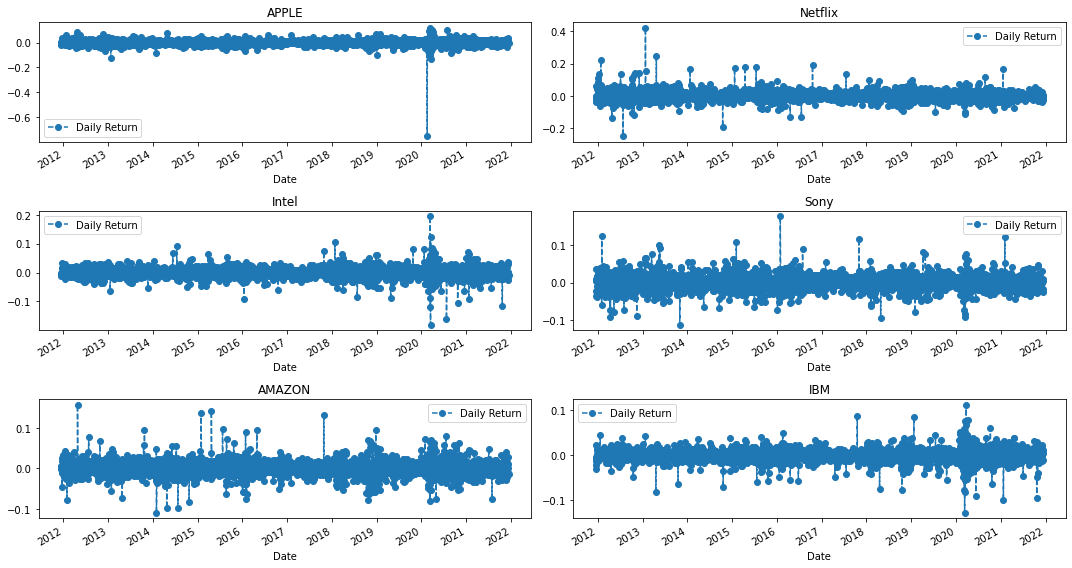

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')
NFLX['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('Netflix')
INTC['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('Intel')
SONY['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('Sony')
AMZN['Daily Return'].plot(ax=axes[2,0], legend=True, linestyle='--', marker='o')
axes[2,0].set_title('AMAZON')
IBM['Daily Return'].plot(ax=axes[2,1], legend=True, linestyle='--', marker='o')
axes[2,1].set_title('IBM')
fig.tight_layout()

The above plot shows the Daily returns of all the stocks plotted against time. It gives us the idea of Volatality in the price changes of a stock. It can be observed that the stocks Amazon & Sony are more volatile as compared to others

In [14]:
# Creating a new DataFrame for Closing prices
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']
closing_df.head()

Symbols,AAPL,NFLX,INTC,SONY,AMZN,IBM
Date,,,,,,
2011-12-13,52.957550,10.301428,17.557196,16.152859,180.509995,133.523941
2011-12-14,51.783474,10.148571,17.370890,15.774632,180.210007,131.826492
2011-12-15,51.613213,9.960000,17.370890,15.857658,181.259995,130.960266
2011-12-16,51.896519,9.974285,17.311275,15.968361,181.259995,128.229065
2011-12-19,52.058609,9.592857,17.210670,15.414862,179.330002,127.754021


In [15]:
# Making a new DataFrame for returns
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,NFLX,INTC,SONY,AMZN,IBM
Date,,,,,,
2011-12-13,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-14,-0.022170,-0.014838,-0.010611,-0.023415,-0.001662,-0.012713
2011-12-15,-0.003288,-0.018581,0.000000,0.005263,0.005826,-0.006571
2011-12-16,0.005489,0.001434,-0.003432,0.006981,0.000000,-0.020855
2011-12-19,0.003123,-0.038241,-0.005812,-0.034662,-0.010648,-0.003705


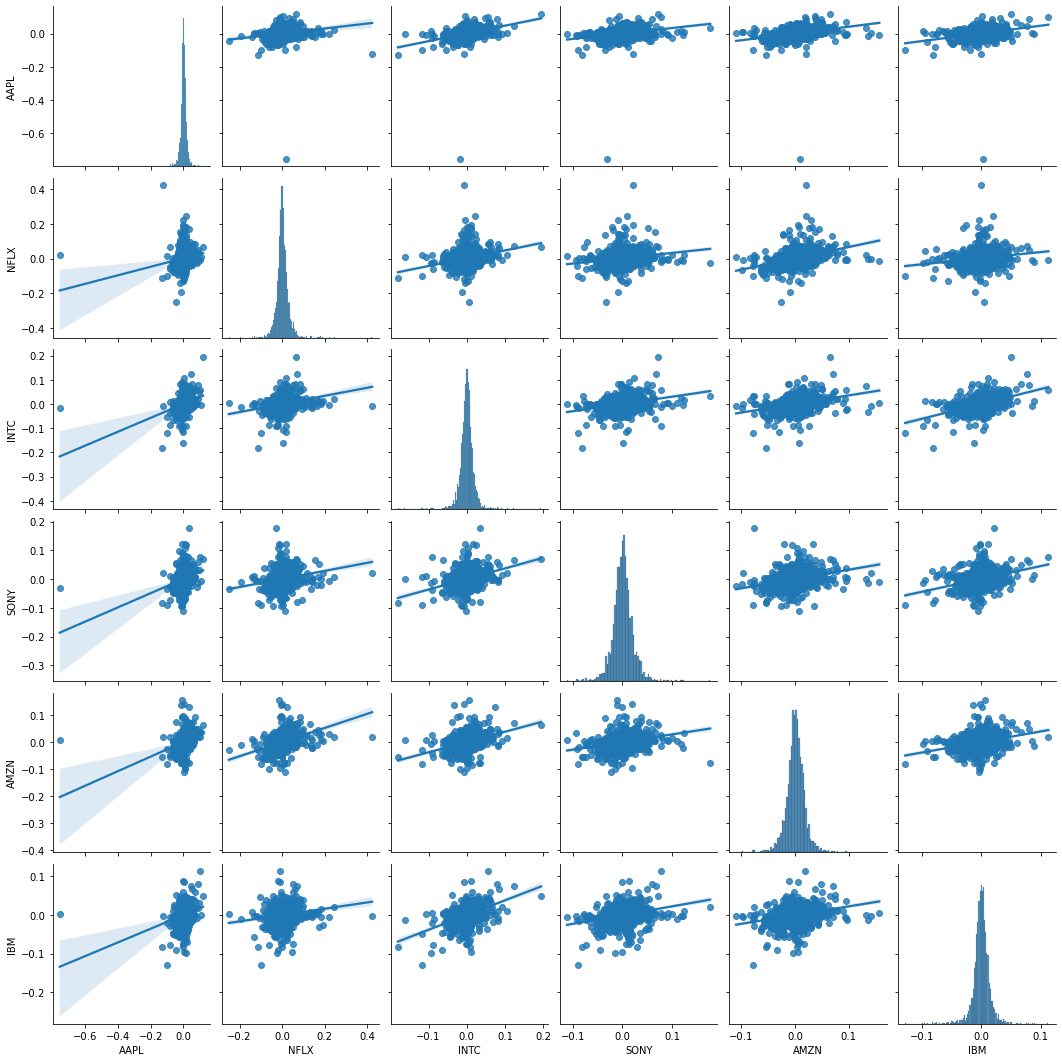

In [16]:
sns.pairplot(tech_rets, kind='reg')

In [17]:
corr = tech_rets.corr()
corr.style.background_gradient(cmap='PuBu').set_precision(2)

Symbols,AAPL,NFLX,INTC,SONY,AMZN,IBM
Symbols,,,,,,
AAPL,1.00,0.19,0.37,0.28,0.33,0.29
NFLX,0.19,1.00,0.27,0.21,0.41,0.17
INTC,0.37,0.27,1.00,0.33,0.37,0.48
SONY,0.28,0.21,0.33,1.00,0.30,0.32
AMZN,0.33,0.41,0.37,0.30,1.00,0.30
IBM,0.29,0.17,0.48,0.32,0.30,1.00


The correlations analysis shows that the stocks IBM-Intel, Intel-Apple and Amazon-Apple are more correlated.

In [18]:
#setting index as date values
# df['Date'] = pd.to_datetime(df.index.values,format='%Y-%m-%d')
df.set_index('Date', drop=True, inplace=True)
df['Date'] = pd.to_datetime(df.index.values,format='%Y-%m-%d')


In [19]:
#Calculating Moving Average with lag of 10, 20, 50 days.
#Moving Average
ma_day = [50, 200, 500]
for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
print(AAPL.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name',
       'Daily Return', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days'],
      dtype='object')


Text(0.5, 1.0, 'IBM')

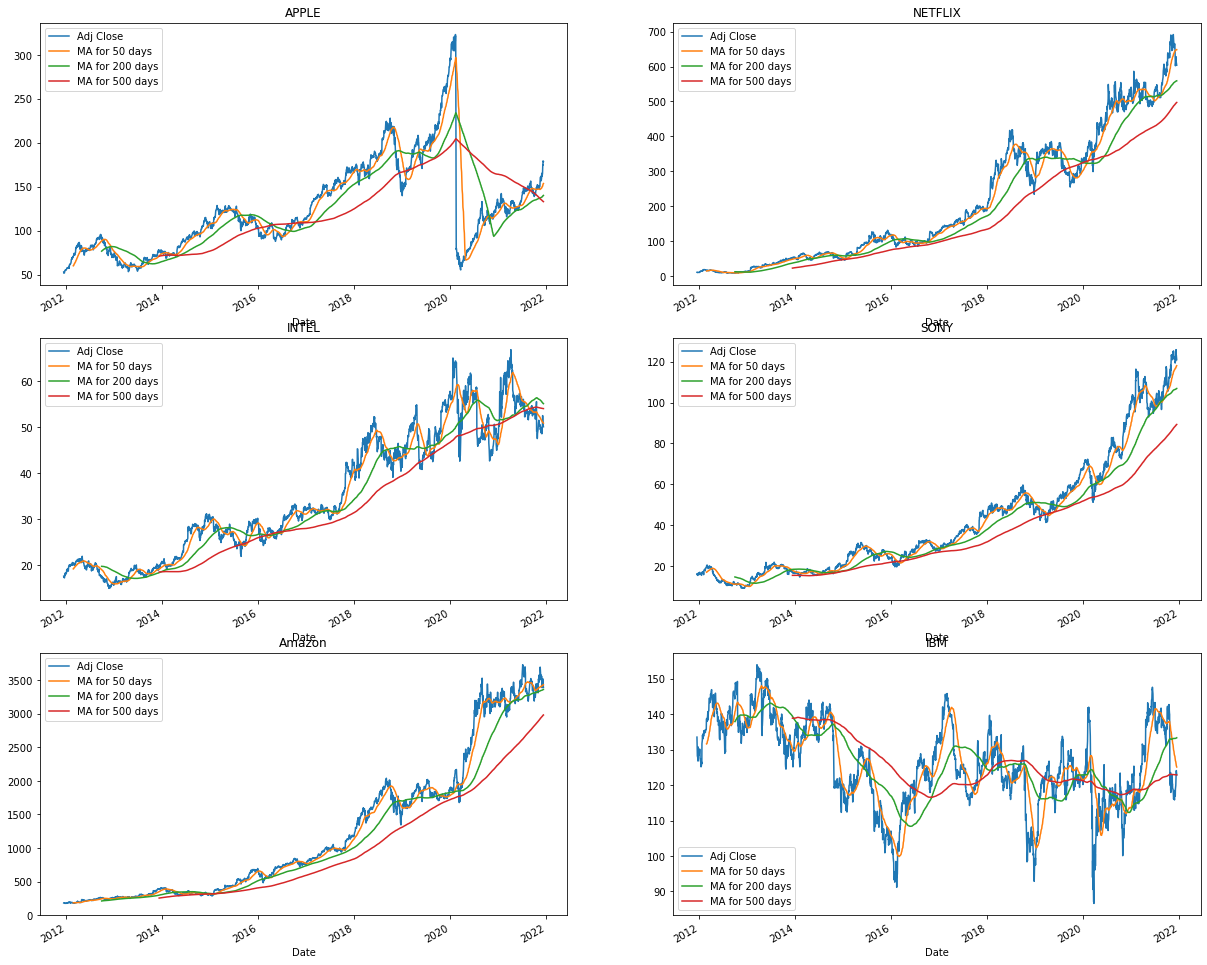

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)
plt.subplots_adjust(top=1.75, bottom=1.5, right=1.2)

AAPL[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')
NFLX[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[0,1])
axes[0,1].set_title('NETFLIX')
INTC[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[1,0])
axes[1,0].set_title('INTEL')
SONY[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[1,1])
axes[1,1].set_title('SONY')
AMZN[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[2,0])
axes[2,0].set_title('Amazon')
IBM[['Adj Close', 'MA for 50 days', 'MA for 200 days', 'MA for 500 days']].plot(ax=axes[2,1])
axes[2,1].set_title('IBM')

#### Prescriptive Analysis Using AutoML Layer

In [5]:
config = configparser.ConfigParser()
config.read('config.ini')

runObj = Generate_Models()
data, y_pred, train_x, train_y, test_x, test_y = runObj.initiate_processing(config,'Netflix')

Executing load_data()
File Name :  TechStockData.csv
Input Dataset Columns :  ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'company_name']
Input Dataset Columns Data Types :  Date            object
High            object
Low             object
Open            object
Close           object
Volume          object
Adj Close       object
company_name    object
dtype: object
Input Dataframe size in memory(kB) :  8297.755859375
Exiting load_data(), Time taken to load : (seconds) 0.5186767578125
Netflix
Extracting features and targets
Initialising model building/training process
Adding Classifier Models
Models List:  {'KNRegressor', 'Linear'}


[{'modelMethodName': 'Linear', 'tuningParameters': [{'n_jobs': [5, 10]}], 'bestConfiguration': []}, {'modelMethodName': 'KNRegressor', 'tuningParameters': [{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}], 'bestConfiguration': []}]


[{'modelMethodName': 'Linear', 'tuningParameters': [{'n_jobs': [5, 10]}], 'bestConfiguration': []}, {'modelMethodName': 'KNRegressor', 'tuningParameters': [{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}], 'bestConfiguration': []}]
Modelling ... 
Finding best configuration params using Grid Search for : Linear
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END .........................n_jobs=10;, score=0.882 total time=   2.9s[CV 3/3] END ..........................n_jobs=5;, score=0.882 total time=   2.9s
[CV 1/3] END ..........................n_jobs=5;, score=0.882 total time=   2.9s

[CV 2/3] END ..........................n_jobs=5;, score=0.890 total time=   2.9s
[CV 3/3] END .........................n_jobs=10;, score=0.882 total time=   0.0s
[CV 2/3] END .........................n_jobs=10;, score=0.890 total time=   0.0s
Best parameters: Linear__{'n_jobs': 5}
Finding best configuration params using Grid Search for : KNRegressor
Fitting 3 folds for each of 8 candidates

In [25]:
netflix_df = data[data['company_name']=='Netflix']
netflix_df.set_index('Date', drop=True, inplace=True)
netflix_df.drop(['company_name','Adj Close', 'High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)

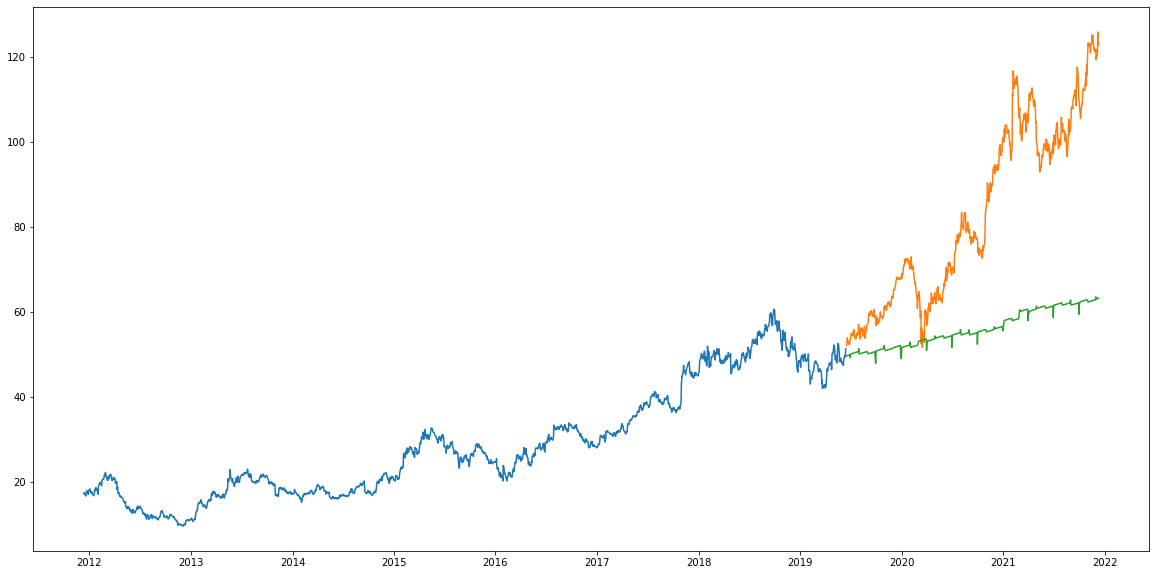

In [26]:
#Linear Regression model for Netflix with best params
split = train_x.shape[0]
train = netflix_df[:split]
valid = netflix_df[split:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

model = LinearRegression()
model.fit(x_train,y_train)
preds = model.predict(x_valid)
valid['Predictions'] = 0
valid['Predictions'] = preds
# plt.savefig("LinearOutputNetflix.png")
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.savefig("LinearOutputNetflix.png")

In [60]:
#Evaluation of Model by Root Mean squared error.
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

130.47128597690033

In [27]:
#KNN model for Apple with best params

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

model = neighbors.KNeighborsRegressor(n_neighbors=2)
model.fit(x_train,y_train)
preds = model.predict(x_valid)

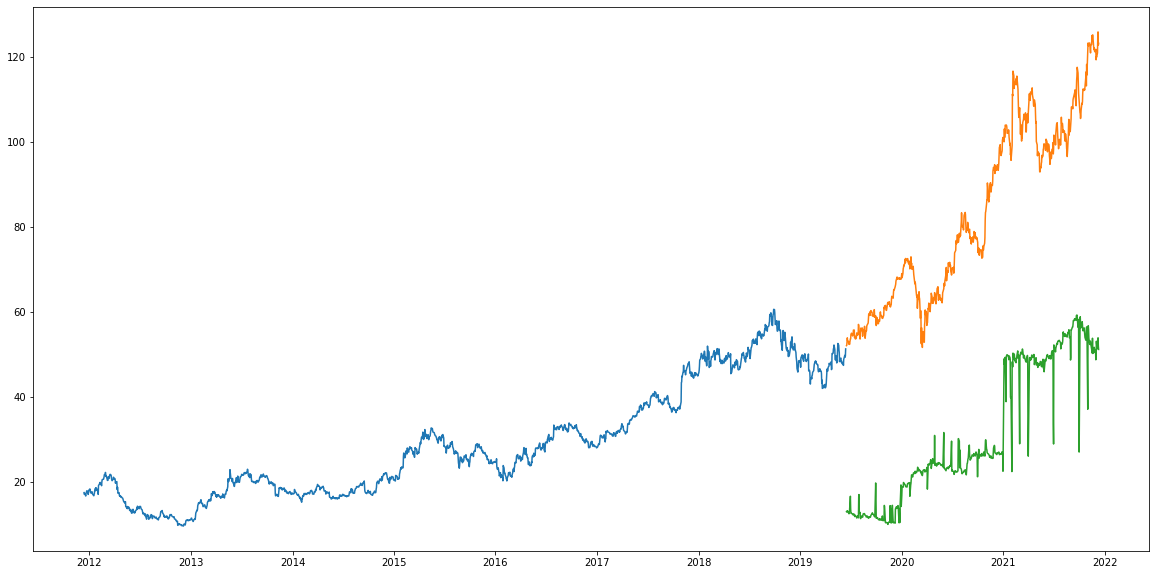

In [28]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.savefig("KnnOutputNetflix.png")

In [13]:
#Evaluation of Model by Root Mean squared error.
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

314.2412066487015

In [29]:
#creating dataframe for LSTM model
netflix_df = data[data['company_name']=='Netflix']
netflix_df = netflix_df.sort_index(ascending=True, axis=0)
netflix_df = netflix_df.reset_index()
netflix_df_new = pd.DataFrame(index=range(0,len(netflix_df)),columns=['Date', 'Close'])
netflix_df_new.head()
for i in range(0,len(netflix_df)):
    netflix_df_new['Date'][i] = netflix_df['Date'][i]
    netflix_df_new['Close'][i] = netflix_df['Close'][i]

#setting index
netflix_df_new.index = netflix_df_new.Date
netflix_df_new.drop('Date', axis=1, inplace=True)


#creating train and test sets
netflix_data = netflix_df_new.values

train = netflix_data[:split]
valid = netflix_data[split:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(netflix_data)

#Lookback period=60
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [30]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = netflix_df_new[len(netflix_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1827/1827 - 89s - loss: 3.3107e-04


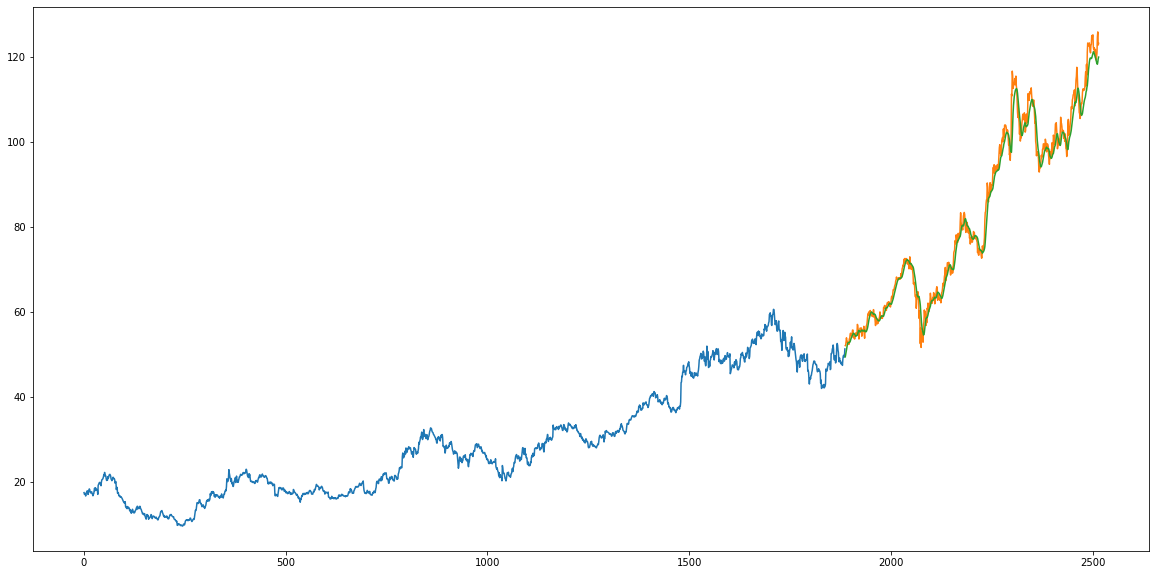

In [31]:
#plot
train = netflix_df[:split]
valid = netflix_df[split:]
valid['Predictions'] = 0
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.savefig("LstmOutputSony.png")

In [17]:
#Evaluation of Model by Root Mean squared error.
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(closing_price)),2)))
rms

144.81314763564416